# Quantitative Report: National GDP Analysis

This report presents an analysis of the Gross Domestic Product (GDP) for the countries of South Africa, Ghana, Nigeria, Kenya, and Egypt.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data from the csv file
data = pd.read_csv('data_nat_gdp.csv')
data.head()

,date,south_africa,ghana,nigeria,kenya,egypt
0,1991-01-01,200.20,6.596546e+09,4.666225e+10,7.777925e+09,3.738784e+10
1,1992-01-01,165.25,6.413902e+09,4.484545e+10,7.854637e+09,4.185599e+10
2,1993-01-01,135.74,5.966256e+09,2.540587e+10,5.391615e+09,4.657863e+10
3,1994-01-01,131.15,5.444561e+09,3.147981e+10,6.785822e+09,5.189798e+10
4,1995-01-01,162.33,6.465138e+09,4.184187e+10,8.726171e+09,6.015925e+10


### Summary Statistics

In [3]:
# create an empty dataframe to store the results
results_df = pd.DataFrame(columns=["Country", "Mean", "SD", "Min", "Max", "25%", "75%"])

# loop over each country in the dataframe and calculate its descriptive statistics
for col in data.columns[1:]:
    # create a new row for the current country
    row = {"Country": col}
    row["Mean"] = '{:.2f}'.format(data[col].mean()/1e9).rstrip('0').rstrip('.') + 'B' if data[col].mean() >= 1e9 else '{:.2f}'.format(data[col].mean()/1e6).rstrip('0').rstrip('.') + 'M' if data[col].mean() >= 1e6 else '{:.2f}'.format(data[col].mean())
    row["SD"] = '{:.2f}'.format(data[col].std()/1e9).rstrip('0').rstrip('.') + 'B' if data[col].std() >= 1e9 else '{:.2f}'.format(data[col].std()/1e6).rstrip('0').rstrip('.') + 'M' if data[col].std() >= 1e6 else '{:.2f}'.format(data[col].std())
    row["Min"] = '{:.2f}'.format(data[col].min()/1e9).rstrip('0').rstrip('.') + 'B' if data[col].min() >= 1e9 else '{:.2f}'.format(data[col].min()/1e6).rstrip('0').rstrip('.') + 'M' if data[col].min() >= 1e6 else '{:.2f}'.format(data[col].min())
    row["Max"] = '{:.2f}'.format(data[col].max()/1e9).rstrip('0').rstrip('.') + 'B' if data[col].max() >= 1e9 else '{:.2f}'.format(data[col].max()/1e6).rstrip('0').rstrip('.') + 'M' if data[col].max() >= 1e6 else '{:.2f}'.format(data[col].max())
    row["25%"] = '{:.2f}'.format(data[col].quantile(0.25)/1e9).rstrip('0').rstrip('.') + 'B' if data[col].quantile(0.25) >= 1e9 else '{:.2f}'.format(data[col].quantile(0.25)/1e6).rstrip('0').rstrip('.') + 'M' if data[col].quantile(0.25) >= 1e6 else '{:.2f}'.format(data[col].quantile(0.25))
    row["75%"] = '{:.2f}'.format(data[col].quantile(0.75)/1e9).rstrip('0').rstrip('.') + 'B' if data[col].quantile(0.75) >= 1e9 else '{:.2f}'.format(data[col].quantile(0.75)/1e6).rstrip('0').rstrip('.') + 'M' if data[col].quantile(0.75) >= 1e6 else '{:.2f}'.format(data[col].quantile(0.75))
    # add the row to the results dataframe
    results_df = pd.concat([results_df, pd.DataFrame(row, index=[0])], ignore_index=True)

# print the results dataframe
results_df

,Country,Mean,SD,Min,Max,25%,75%
0,south_africa,111.61,44.14,45.42,200.20,79.96,134.84
1,ghana,28.49B,24.98B,4.98B,77.59B,6.74B,52.09B
2,nigeria,234.13B,177.1B,25.41B,555.02B,55.06B,399.12B
3,kenya,37.68B,31.94B,5.39B,108.69B,12.78B,57.54B
4,egypt,168.63B,112.25B,37.39B,404.14B,79.54B,264.41B


### Performance Visualization

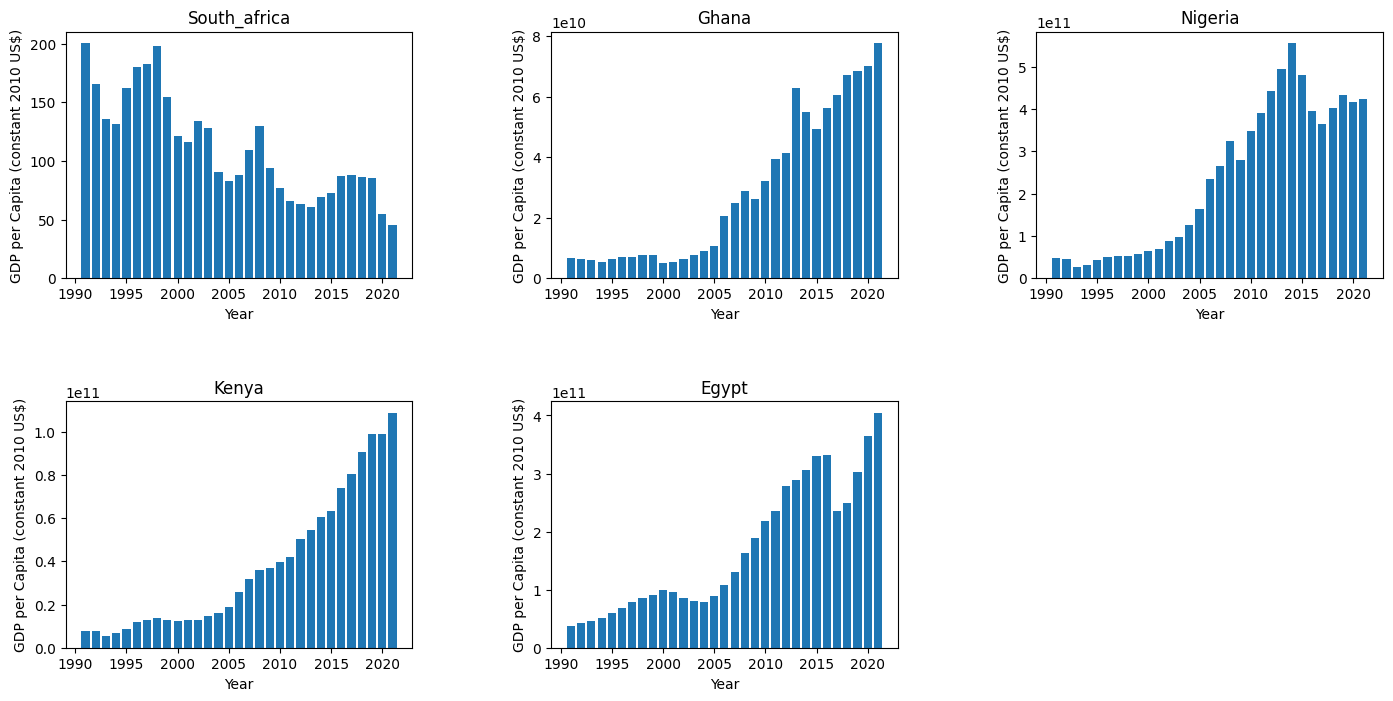

In [4]:
# Create a list of countries
countries = ['south_africa', 'ghana', 'nigeria', 'kenya', 'egypt']

# Set the number of rows and columns of subplots
num_rows = 2
num_cols = 3

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(17, 8))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Define a function to extract the year from a date string
def get_year(date_str):
    return int(date_str[:4])

# Plot each country's time series in a separate chart
for i, country in enumerate(countries):
    # Extract the year from each date string
    years = np.array([get_year(date) for date in data['date']])
    axs[i].bar(years, data[country])
    axs[i].set_title(country.capitalize())
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('GDP per Capita (constant 2010 US$)')

# Hide the empty subplots
for i in range(len(countries), num_rows*num_cols):
    axs[i].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Show the plot
plt.show()


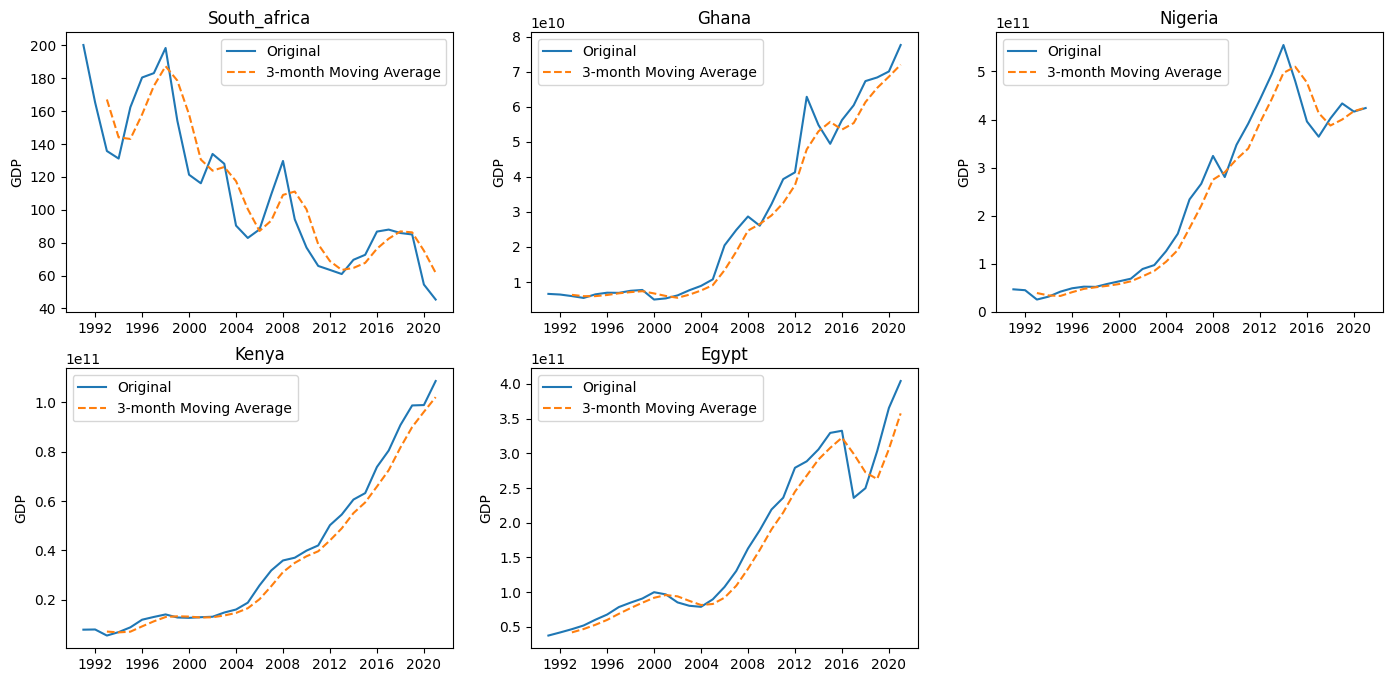

In [5]:
import os
plots_dir = 'plots/'

# Create the "plots" directory if it doesn't exist
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Convert date column to datetime format and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Define the window size for the moving average
window_size = 3

# Define countries
countries = ['south_africa', 'ghana', 'nigeria', 'kenya', 'egypt']

# Calculate the rolling mean for each country's GDP data
data_mean = data.rolling(window=window_size).mean()

# Create a grid of subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 8))

# Plot the original and moving average data for each country's GDP
for i in range(len(countries)):
    row = i // 3
    col = i % 3
    axes[row, col].plot(data.index, data[countries[i]], label='Original')
    axes[row, col].plot(data_mean.index, data_mean[countries[i]], label=f'{window_size}-month Moving Average', linestyle='--')
    axes[row, col].set_title(countries[i].capitalize())
    axes[row, col].set_ylabel('GDP')
    axes[row, col].legend(loc='best')

# Hide the last subplot
axes[1, 2].axis('off')

# Save the plot to the 'plots' folder
plt.savefig(plots_dir + 'gdp_original_3monthMVA.png')

plt.show()

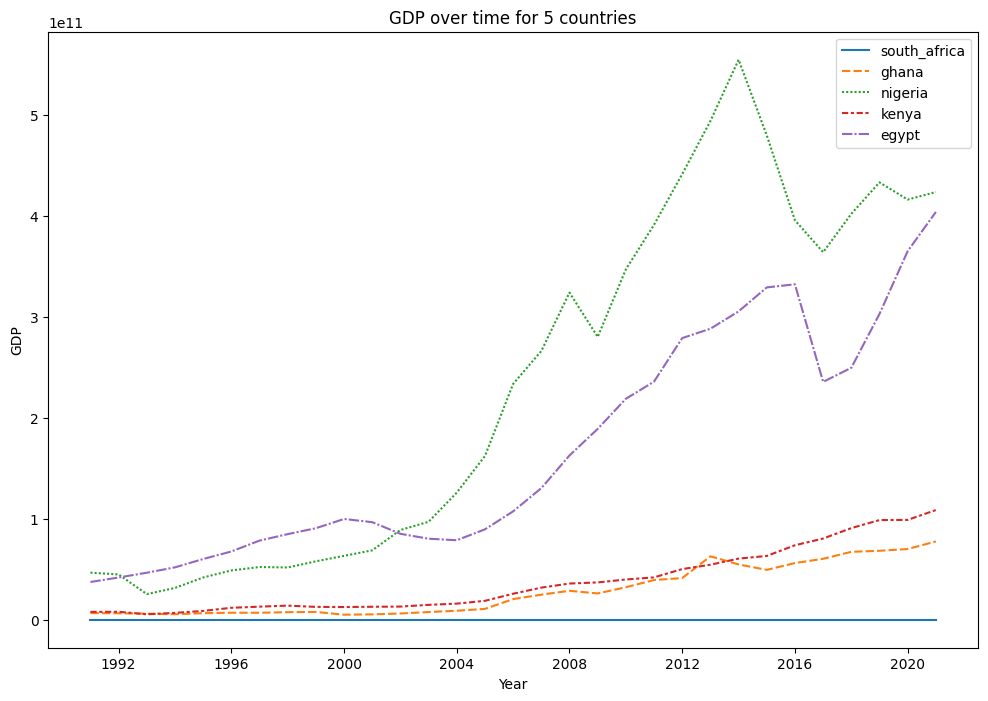

In [6]:
# Convert infinite values to NaN in the entire dataframe
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Time series visualization
plt.figure(figsize=(12, 8))
sns.lineplot(data=data)
plt.title('GDP over time for 5 countries')
plt.xlabel('Year')
plt.ylabel('GDP')
# Save the plot to the 'plots' folder
plt.savefig(plots_dir + 'gdp_stacked.png')
plt.show()


In [7]:
from sklearn.linear_model import LinearRegression

def run_log_linear_regression(data, country):
    # Define independent variables (exclude the specified country as dependent variable)
    X = data.drop([country], axis=1)
    
    # Define dependent variable (take the log of the specified country)
    y = np.log(data[country])
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    
    # Extract model coefficients
    coef = model.coef_
    coef_rounded = [round(num, 2) if abs(num) >= 0.01 else f"{num:.2e}" for num in coef]
    intercept = model.intercept_
    intercept_rounded = round(intercept, 2) if abs(intercept) >= 0.01 else f"{intercept:.2e}"
    r_squared = model.score(X, y)
    r_squared_rounded = round(r_squared, 2) if abs(r_squared) >= 0.01 else f"{r_squared:.2e}"
    
    # Return regression results
    return coef_rounded, intercept_rounded, r_squared_rounded

# Run log-linear regression for each country
countries = ['ghana', 'nigeria', 'kenya', 'egypt', 'south_africa']
results = [run_log_linear_regression(data, country) for country in countries]

# Display regression results in two rows
for i in range(len(countries)):
    print("Log-Linear Regression Results for " + countries[i].capitalize() + ":")
    print("Coefficients:", results[i][0])
    print("Intercept:", results[i][1])
    print("R-squared:", results[i][2])
    print("="*80)


Log-Linear Regression Results for Ghana:
Coefficients: ['8.99e-04', '4.66e-12', '1.54e-11', '-2.17e-12']
Intercept: 22.21
R-squared: 0.98
Log-Linear Regression Results for Nigeria:
Coefficients: ['-9.04e-03', '2.50e-11', '-1.09e-11', '2.71e-12']
Intercept: 26.02
R-squared: 0.84
Log-Linear Regression Results for Kenya:
Coefficients: ['-8.17e-04', '1.66e-11', '1.75e-12', '1.33e-12']
Intercept: 22.95
R-squared: 0.93
Log-Linear Regression Results for Egypt:
Coefficients: ['-1.51e-03', '-1.85e-11', '3.24e-12', '1.75e-11']
Intercept: 24.89
R-squared: 0.93
Log-Linear Regression Results for South_africa:
Coefficients: ['4.75e-12', '-1.18e-12', '-7.92e-13', '-2.10e-12']
Intercept: 5.16
R-squared: 0.76


### Econometrics Model

$$
\begin{pmatrix}
    \hat{y_g} \\
    \hat{y_n} \\
    \hat{y_k} \\
    \hat{y_e} \\
    \hat{y_s}
\end{pmatrix}
\ =
\begin{pmatrix}
    22.21 \\
    26.02 \\
    22.95 \\
    24.89 \\
    5.16
\end{pmatrix}
\ +
\begin{pmatrix}
      0 & 8.99e-04 & 4.66e-12 & 1.54e-11 & -2.17e-12 \\
      -9.04e-03 & 0 & 2.50e-11 & -1.09e-11 & 2.71e-12 \\
      -8.17e-04 & 1.66e-11 & 0 & 1.75e-12 & 1.33e-12 \\
      -1.51e-03 & -1.85e-11 & 3.24e-12 & 0 & 1.75e-11 \\
      4.75e-12 & -1.18e-12 & -7.92e-13 & -2.10e-12 & 0
\end{pmatrix}
\
\begin{pmatrix}
    log{(Ghana)} \\
    log{(Nigeria)}  \\
    log{(Kenya)}  \\
    log{(Ethiopia)}  \\
    log{(RSA)} 
\end{pmatrix}
\ +
\begin{pmatrix}
    \epsilon_g \\
    \epsilon_n \\
    \epsilon_k \\
    \epsilon_e \\
    \epsilon_s
\end{pmatrix}
$$

In [8]:
def run_ols(data, country):
    # Define independent variables (exclude the specified country as dependent variable)
    X = data.drop([country], axis=1)
    
    # Define dependent variable
    y = data[country]
    
    # Fit OLS model
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    # Return regression results
    return model

def hypothesis_tests(data, countries, alpha=0.05):
    for country in countries:
        # Run OLS for current country
        model = run_ols(data, country)
        
        # Perform t-tests for each coefficient
        print("T-Tests for " + country.capitalize() + ":")
        for coeff, t_stat, p_val in zip(model.params.index, model.tvalues, model.pvalues):
            if p_val < alpha:
                print(coeff + ": t = {:.2f}, p = {:.2e} (significant)".format(t_stat, p_val))
            else:
                print(coeff + ": t = {:.2f}, p = {:.2e}".format(t_stat, p_val))
        
        # Perform F-test for overall model
        if model.f_pvalue < alpha:
            print("F-Test for Overall Model: F = {:.2f}, p = {:.2e} (significant)\n".format(model.fvalue, model.f_pvalue))
        else:
            print("F-Test for Overall Model: F = {:.2f}, p = {:.2e}\n".format(model.fvalue, model.f_pvalue))



In [9]:
hypothesis_tests(data, ['ghana', 'nigeria', 'kenya', 'egypt', 'south_africa'], alpha=0.05)

T-Tests for Ghana:
const: t = -1.51, p = 1.42e-01
south_africa: t = 0.99, p = 3.33e-01
nigeria: t = 4.21, p = 2.72e-04 (significant)
kenya: t = 9.56, p = 5.32e-10 (significant)
egypt: t = 0.06, p = 9.56e-01
F-Test for Overall Model: F = 338.37, p = 5.21e-22 (significant)

T-Tests for Nigeria:
const: t = 2.42, p = 2.29e-02 (significant)
south_africa: t = -2.31, p = 2.88e-02 (significant)
ghana: t = 4.21, p = 2.72e-04 (significant)
kenya: t = -3.70, p = 1.00e-03 (significant)
egypt: t = 2.63, p = 1.41e-02 (significant)
F-Test for Overall Model: F = 90.98, p = 6.76e-15 (significant)

T-Tests for Kenya:
const: t = 0.95, p = 3.51e-01
south_africa: t = -0.72, p = 4.81e-01
ghana: t = 9.56, p = 5.32e-10 (significant)
nigeria: t = -3.70, p = 1.00e-03 (significant)
egypt: t = 1.78, p = 8.61e-02
F-Test for Overall Model: F = 221.50, p = 1.12e-19 (significant)

T-Tests for Egypt:
const: t = 1.36, p = 1.85e-01
south_africa: t = -0.68, p = 5.04e-01
ghana: t = 0.06, p = 9.56e-01
nigeria: t = 2.63, p 

In [10]:
import warnings

# Define dependent variables
countries = ['south_africa', 'ghana', 'nigeria', 'kenya', 'egypt']
data_countries = [data[country] for country in countries]


# Fit ARIMA models and print summaries
for i, y in enumerate(data_countries):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = sm.tsa.ARIMA(y, order=(1,1,1)).fit()
        print(f"ARIMA Summary for {countries[i].capitalize().replace('_', ' ')}")
        print(model.summary())

ARIMA Summary for South africa
                               SARIMAX Results                                
Dep. Variable:           south_africa   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -130.193
Date:                Sat, 23 Mar 2024   AIC                            266.386
Time:                        09:32:58   BIC                            270.589
Sample:                    01-01-1991   HQIC                           267.730
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1470      0.661     -0.222      0.824      -1.443       1.148
ma.L1          0.6015      0.487      1.235      0.217      -0.353       1.556
sigma2       341.0402

### Pre and Post COVID Analysis

In [11]:
from scipy.stats import ttest_ind

# Read the data from the csv file
data_comp = pd.read_csv('data_nat_gdp.csv')
data_comp['date'] = pd.to_datetime(data_comp['date'], errors='coerce').dt.year

# Define a column that indicates whether the data was collected pre- or post-COVID-19
data_comp['period'] = np.where(data_comp['date'] < 2020, 0, 1)

# Initialize an empty list to store rows
rows = []

# Loop over each column in the dataframe and calculate its mean for pre- and post-COVID-19 periods
data_comp['date'] = data_comp['date'].astype(int, errors='ignore')
for col in data_comp.columns[1:-1]:
    pre_covid_mean = data_comp.loc[data_comp['period'] == 0, col].mean()
    post_covid_mean = data_comp.loc[data_comp['period'] == 1, col].mean()
    t_statistic, p_value = ttest_ind(data_comp.loc[data_comp['period'] == 0, col], data_comp.loc[data_comp['period'] == 1, col])
    row = {"Country": col, "Pre-COVID-19 Mean": pre_covid_mean, "Post-COVID-19 Mean": post_covid_mean,
           "T-statistic": t_statistic, "P-value": p_value}
    rows.append(row)

# Concatenate the list of rows into a DataFrame
results_df = pd.DataFrame(rows)

# Print the results dataframe
print(results_df)


        Country  Pre-COVID-19 Mean  Post-COVID-19 Mean  T-statistic   P-value
0  south_africa       1.158572e+02        4.998500e+01     2.162838  0.038937
1         ghana       2.536751e+10        7.381874e+10    -2.981627  0.005757
2       nigeria       2.213009e+11        4.201560e+11    -1.573123  0.126538
3         kenya       3.311728e+10        1.038111e+11    -3.572066  0.001261
4         egypt       1.537280e+11        3.846977e+11    -3.225538  0.003109


In [12]:
from scipy.stats import ttest_rel

# Load data
data_comp = pd.read_csv('data_nat_gdp.csv')
data_comp['date'] = pd.to_datetime(data_comp['date'], format='%Y-%m-%d')

# Define pre-covid period and post-covid period
pre_covid_period = data_comp[(data_comp['date'] >= '2018-01-01') & (data_comp['date'] < '2020-06-30')]
post_covid_period = data_comp[(data_comp['date'] >= '2020-07-01')]

# Calculate mean GDP for each country in pre-covid period and post-covid period
pre_covid_means = pre_covid_period.mean().drop(['date'])
post_covid_means = post_covid_period.mean().drop(['date'])

# Perform paired t-test to test for significant difference in means
t_statistic, p_value = ttest_rel(pre_covid_means, post_covid_means)

# Output results
alpha = 0.05
if p_value < alpha:
    print("There is significant evidence to reject the null hypothesis that there was no significant change in the economy post-covid.")
else:
    print("There is not enough evidence to reject the null hypothesis that there was no significant change in the economy post-covid.")


There is not enough evidence to reject the null hypothesis that there was no significant change in the economy post-covid.
